# Predicting Medical Insurance Costs with Linear Regression

## Introduction

Healthcare costs are influenced by many factors such as age, BMI, smoking habits, and lifestyle choices. Insurance companies rely on predictive models to estimate these costs and set fair premiums.  

In this project, we use the [**Medical Cost Personal Dataset**](https://www.kaggle.com/datasets/mirichoi0218/insurance) from Kaggle, which includes patient information (age, sex, BMI, smoker status, number of children, region) and their corresponding **medical charges**.  

Our goal is to:
- Explore the data and identify key patterns.  
- Build a **Linear Regression model** to predict medical charges.  
- Interpret the results to see how different factors affect costs.  

This project serves as a beginner-friendly introduction to machine learning in healthcare, combining data analysis with practical model building.

## 1. Import Libraries

In [1]:
import math
import warnings

# Data manipulation
import numpy as np
import pandas as pd

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning tools
import statsmodels.api as sm
from scipy.special import inv_boxcox
from scipy.stats import f_oneway, boxcox
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_log_error
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures

warnings.filterwarnings('ignore')  # Supress unnecessary warnings

# Setup default plot styles
sns.set(style='white')
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.grid.axis'] = 'y'
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['grid.alpha'] = 0.5

## Helper Functions

In [2]:
def plot_numerical_variables(data, col):
    """
    Plots the distribution of numerical variables.
    :param data: (dataframe) dataset
    :param col: (string) column name
    :return: None
    """
    plt.figure(figsize=(14, 5))

    # Histogram
    plt.subplot(1, 2, 1)
    sns.histplot(data[col], kde=True)
    plt.title(f'Distribution of {col.capitalize()}', fontsize=16)
    plt.xlabel(col.capitalize(), fontsize=14)
    plt.ylabel('Count', fontsize=14)

    # Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(data[col], color='lightgreen')
    plt.title(f'Boxplot of {col.capitalize()}', fontsize=16)
    plt.ylabel('Count', fontsize=14)

In [3]:
def outliers_skew(data, col):
    """
    Checks for outliers and skews.
    :param data: (dataframe) dataset
    :param col: (string) column name
    :return: None
    """
    q1 = data[col].quantile(0.25)
    q3 = data[col].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - iqr * 1.5
    upper = q3 + iqr * 1.5
    outliers = data[(data[col] < lower) | (data[col] > upper)][col]
    print(f'Outliers: {len(outliers)}')
    print(f'Skew: {data[col].skew():.2f}', '\n')

## 2. Import and Preview Dataset

In [4]:
# Load and preview a few rows of the data
data = pd.read_csv('medical-insurance.csv')
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [5]:
# Preview data information
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [6]:
# Preview categorical variables
categorical_vars = data.select_dtypes(include=['object']).columns

for col in categorical_vars:
    unique_vals = data[col].unique().tolist()

    print(f'=== {col} ===')
    print(unique_vals, '\n')

=== sex ===
['female', 'male'] 

=== smoker ===
['yes', 'no'] 

=== region ===
['southwest', 'southeast', 'northwest', 'northeast'] 



## 3. Data Cleaning

### 3.1 Duplicates

In [7]:
# Check for duplicated rows
print(f'Duplicated rows: {data.duplicated().sum()}')

Duplicated rows: 1


In [8]:
# Drop duplicates
data = data.drop_duplicates()

### 3.2 Missing Values

In [9]:
# Total missing values
print(f'Missing values: {data.isnull().sum().sum()}')

Missing values: 0


## 4. EDA & Hypothesis Tests

### 4.1 Distribution of Target Variable `charges`

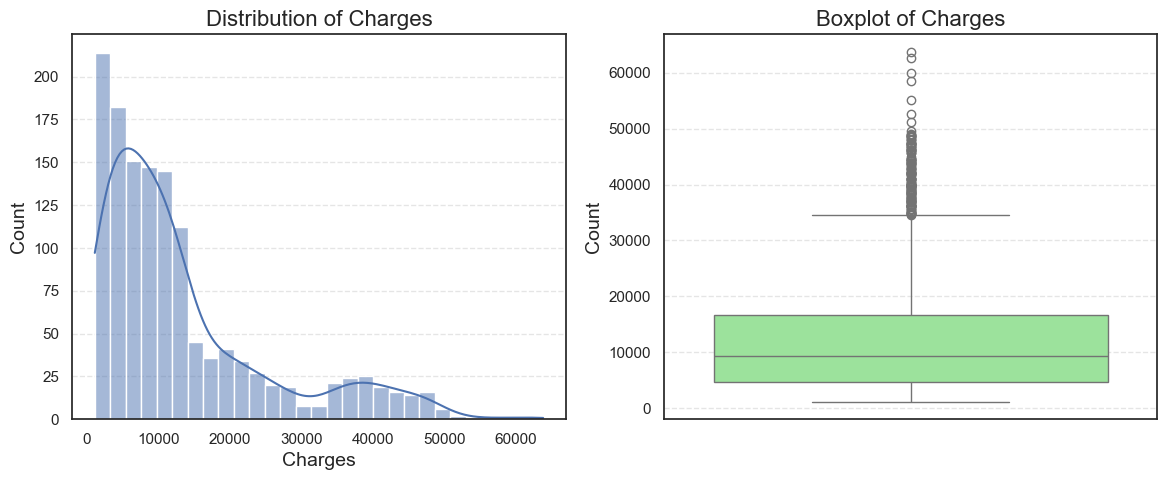

In [10]:
plot_numerical_variables(data=data, col='charges')

In [11]:
# Statistical information
data['charges'].describe()

count     1337.000000
mean     13279.121487
std      12110.359656
min       1121.873900
25%       4746.344000
50%       9386.161300
75%      16657.717450
max      63770.428010
Name: charges, dtype: float64

In [12]:
# Check for outliers and skew
outliers_skew(data=data, col='charges')

Outliers: 139
Skew: 1.52 



### 4.2 Categorical Variables

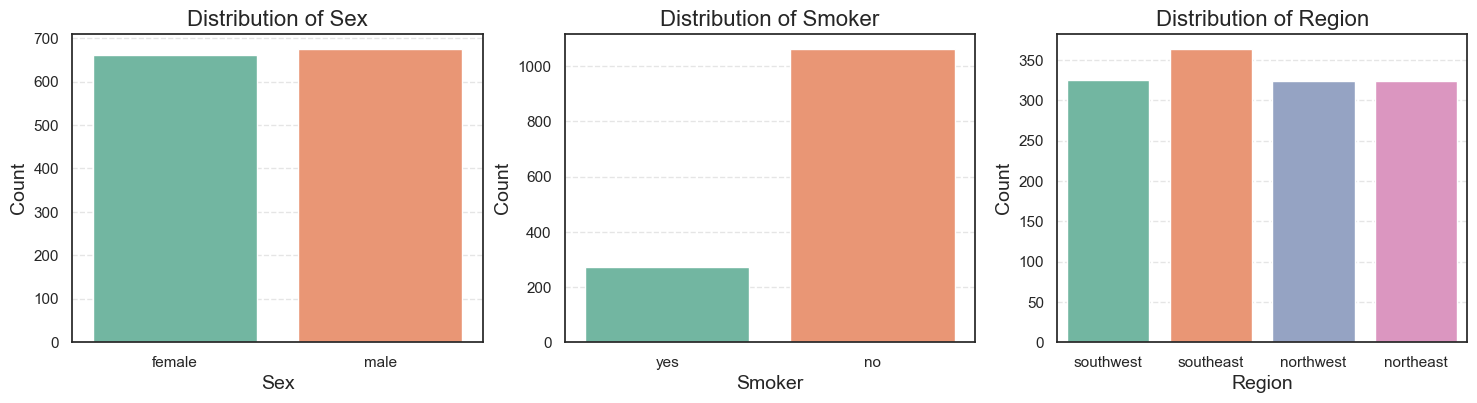

In [13]:
# Distribution of categorical variables
n_cols = 3
n_rows = math.ceil(len(categorical_vars) / n_cols)
plt.figure(figsize=(6 * n_cols, 4 * n_rows))

for i, col in enumerate(categorical_vars, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.countplot(x=data[col], palette='Set2')
    plt.title(f'Distribution of {col.capitalize()}', fontsize=16)
    plt.xlabel(col.capitalize(), fontsize=14)
    plt.ylabel('Count', fontsize=14)

plt.show()

In [14]:
# Variable counts
for col in categorical_vars:
    count = data[col].value_counts().to_frame(name='Count').assign(
        Percent=lambda x: round((x['Count'] / x['Count'].sum()) * 100, 2))

    print(f'=== {col} ===')
    print(count, '\n')

=== sex ===
        Count  Percent
sex                   
male      675    50.49
female    662    49.51 

=== smoker ===
        Count  Percent
smoker                
no       1063    79.51
yes       274    20.49 

=== region ===
           Count  Percent
region                   
southeast    364    27.23
southwest    325    24.31
northwest    324    24.23
northeast    324    24.23 



In [15]:
# Statistical information
data[categorical_vars].describe().T

,count,unique,top,freq
sex,1337,2,male,675
smoker,1337,2,no,1063
region,1337,4,southeast,364


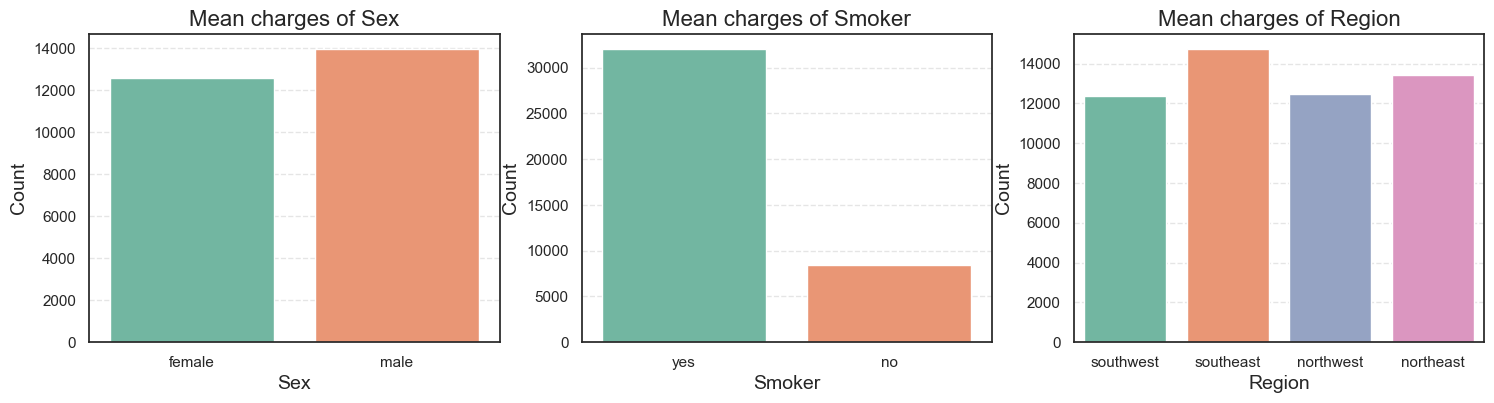

In [16]:
# Mean charges of categorical variables
n_cols = 3
n_rows = math.ceil(len(categorical_vars) / n_cols)
plt.figure(figsize=(6 * n_cols, 4 * n_rows))

for i, col in enumerate(categorical_vars, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.barplot(data=data, x=col, y='charges', estimator='mean', ci=None, palette='Set2')
    plt.title(f'Mean charges of {col.capitalize()}', fontsize=16)
    plt.xlabel(col.capitalize(), fontsize=14)
    plt.ylabel('Count', fontsize=14)

In [17]:
for col in categorical_vars:
    average_charges = data.groupby(col)['charges'].mean().to_frame(name='Mean')

    print(f'=== {col} ===')
    print(average_charges, '\n')

=== sex ===
                Mean
sex                 
female  12569.578844
male    13974.998864 

=== smoker ===
                Mean
smoker              
no       8440.660307
yes     32050.231832 

=== region ===
                   Mean
region                 
northeast  13406.384516
northwest  12450.840844
southeast  14735.411438
southwest  12346.937377 



In [18]:
# ANOVA test
alpha = 0.05
for col in categorical_vars:
    groups = [group['charges'] for _, group in data.groupby(col)]
    f_stats, p_value = f_oneway(*groups)

    print(f'=== {col} ===')
    print(f'f-stats: {f_stats:.2f}, p-value: {p_value}')
    print(f'Null Hypothesis: Average charges are the same across {col}.')
    decision = "Reject the null hypothesis." if p_value < alpha else "Failed to the null reject hypothesis."
    print(f'Decision: {decision}', '\n')

=== sex ===
f-stats: 4.51, p-value: 0.033820791995078286
Null Hypothesis: Average charges are the same across sex.
Decision: Reject the null hypothesis. 

=== smoker ===
f-stats: 2175.74, p-value: 1.4067220949358597e-282
Null Hypothesis: Average charges are the same across smoker.
Decision: Reject the null hypothesis. 

=== region ===
f-stats: 2.93, p-value: 0.03276288025444947
Null Hypothesis: Average charges are the same across region.
Decision: Reject the null hypothesis. 



### 4.3 Numerical Variables

In [19]:
numerical_cols = data.select_dtypes(include='number').columns
numerical_vars = numerical_cols.drop(['charges'])

# Statistical information
data[numerical_vars].describe().T

,count,mean,std,min,25%,50%,75%,max
age,1337.0,39.222139,14.044333,18.00,27.00,39.0,51.0,64.00
bmi,1337.0,30.663452,6.100468,15.96,26.29,30.4,34.7,53.13
children,1337.0,1.095737,1.205571,0.00,0.00,1.0,2.0,5.00


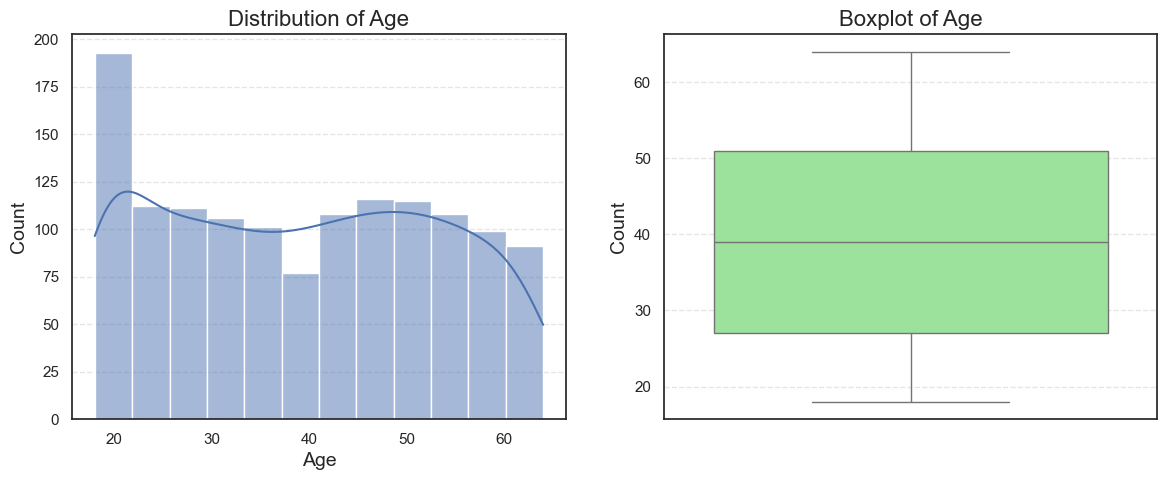

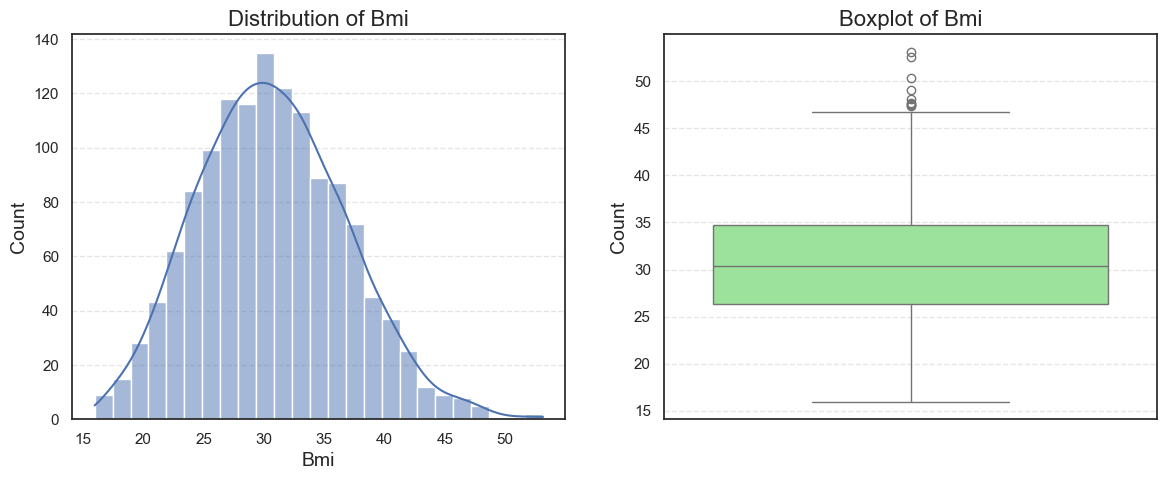

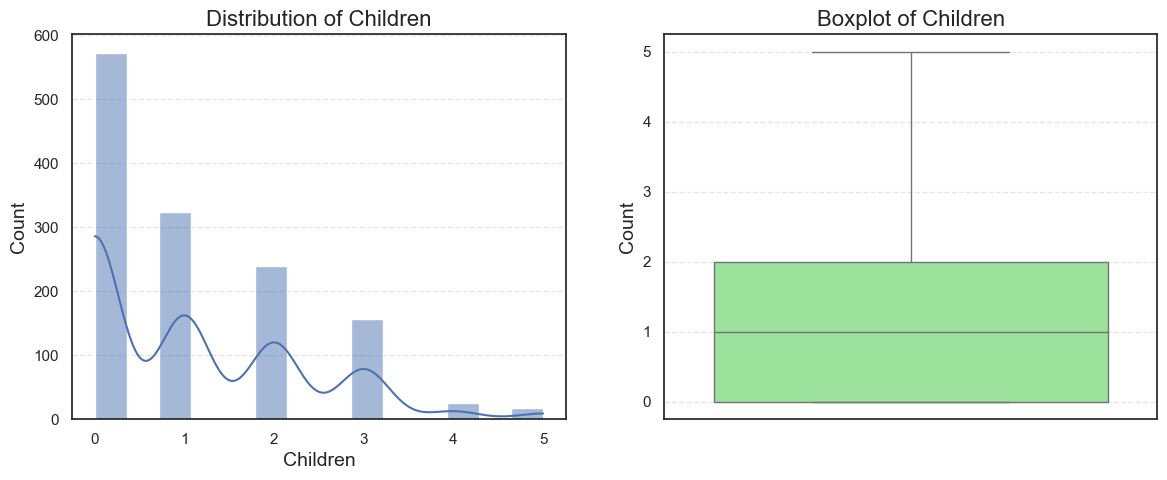

In [20]:
# Distribution of Numerical variables
for col in numerical_vars:
    plot_numerical_variables(data=data, col=col)

plt.show()

In [21]:
# Check for outliers and skew
for col in numerical_vars:
    print(f'=== {col} ===')
    outliers_skew(data=data, col=col)

=== age ===
Outliers: 0
Skew: 0.05 

=== bmi ===
Outliers: 9
Skew: 0.28 

=== children ===
Outliers: 0
Skew: 0.94 



In [22]:
# Check for multi collinearity
corr_mat = data[numerical_vars].corr()
upper_mat = corr_mat.where(np.triu(np.ones(corr_mat.shape), k=1).astype(bool))
mult_col = [col for col in upper_mat.columns if any(upper_mat[col] > 0.8)]
print(f'Multi-collinear: {len(mult_col)}')

Multi-collinear: 0


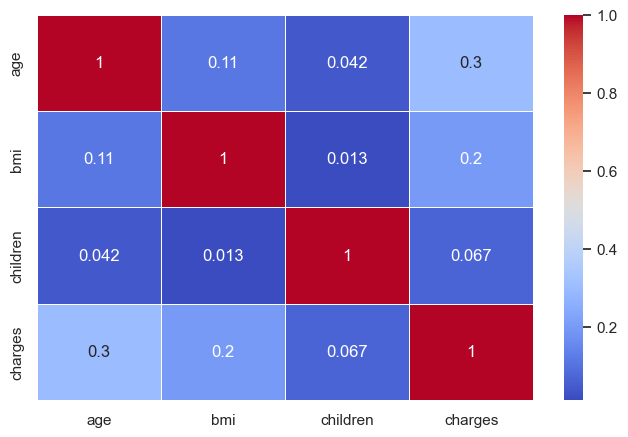

In [23]:
# Check for collinearity with the target (charges)
corr = data[numerical_cols].corr()

plt.figure(figsize=(8, 5))
sns.heatmap(corr, annot=True, cmap='coolwarm', linewidths=0.5)
plt.show()

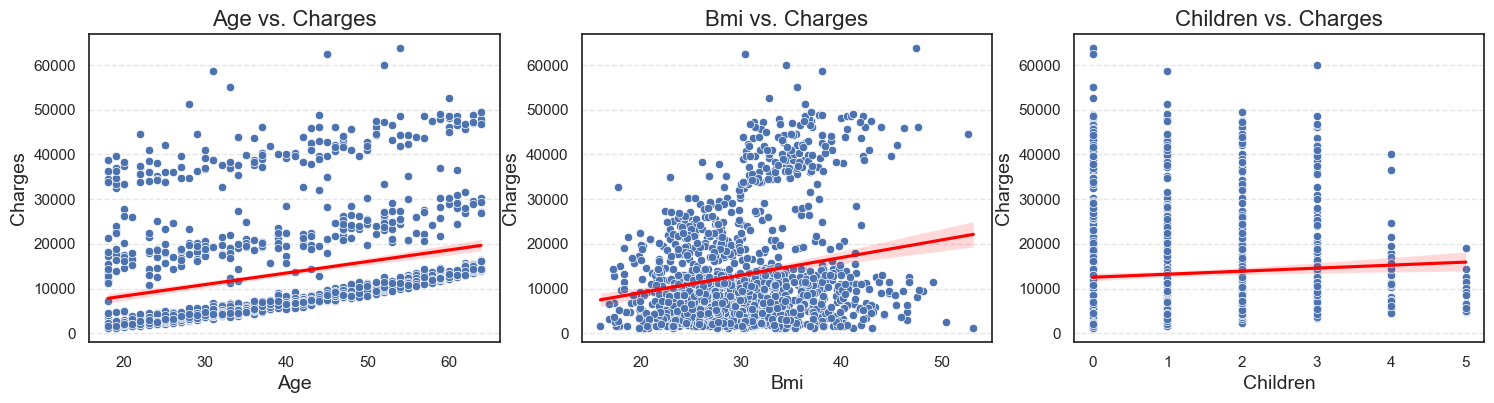

In [24]:
# Check for relationship with target (charges)
n_cols = 3
n_rows = math.ceil(len(numerical_vars) / n_cols)
plt.figure(figsize=(6 * n_cols, 4 * n_rows))

for i, col in enumerate(numerical_vars, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.scatterplot(data=data, x=col, y='charges')
    sns.regplot(data=data, x=col, y='charges', scatter=False, color='red')
    plt.title(f'{col.capitalize()} vs. Charges', fontsize=16)
    plt.xlabel(col.capitalize(), fontsize=14)
    plt.ylabel('Charges', fontsize=14)

plt.show()

In [25]:
# Testing for prediction of target
alpha = 0.05
for col in numerical_vars:
    x = data[col]
    y = data['charges']
    x = sm.add_constant(x)
    model = sm.OLS(y, x).fit()
    p_value = model.pvalues[col]

    print(f'=== {col} ===')
    print(f'Null hypothesis: {col} is not a strong predictor of charges.')
    print(f'p-value: {p_value}')
    decision = 'Reject the null hypothesis.' if p_value < alpha else 'Fail to reject the null hypothesis.'
    print(f'Decision: {decision}', '\n')

=== age ===
Null hypothesis: age is not a strong predictor of charges.
p-value: 6.975748762691412e-29
Decision: Reject the null hypothesis. 

=== bmi ===
Null hypothesis: bmi is not a strong predictor of charges.
p-value: 2.4680404264514124e-13
Decision: Reject the null hypothesis. 

=== children ===
Null hypothesis: children is not a strong predictor of charges.
p-value: 0.013717026292986987
Decision: Reject the null hypothesis. 



## 5. Feature Engineering

### 5.1 Binary Encoding

In [26]:
data_encoded = data.copy()

sex_dict = {
    'female': 0,
    'male': 1
}

smoker_dict = {
    'yes': 1,
    'no': 0
}

data_encoded['sex'] = data_encoded['sex'].map(sex_dict)
data_encoded['smoker'] = data_encoded['smoker'].map(smoker_dict)

data_encoded.head()

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,1,southwest,16884.92400
1,18,1,33.770,1,0,southeast,1725.55230
2,28,1,33.000,3,0,southeast,4449.46200
3,33,1,22.705,0,0,northwest,21984.47061
4,32,1,28.880,0,0,northwest,3866.85520


### 5.2 One-Hot Encoding `region`

In [27]:
ohe = OneHotEncoder()
matrix = ohe.fit_transform(data[['region']]).toarray()
categories = ohe.get_feature_names_out(['region'])
data_encoded[categories] = matrix
data_encoded = data_encoded.drop(columns=['region'])

data_encoded.head()

,age,sex,bmi,children,smoker,charges,region_northeast,region_northwest,region_southeast,region_southwest
0,19,0,27.900,0,1,16884.92400,0.0,0.0,0.0,1.0
1,18,1,33.770,1,0,1725.55230,0.0,0.0,1.0,0.0
2,28,1,33.000,3,0,4449.46200,0.0,0.0,1.0,0.0
3,33,1,22.705,0,0,21984.47061,0.0,1.0,0.0,0.0
4,32,1,28.880,0,0,3866.85520,0.0,1.0,0.0,0.0


## 6. Linear Regression Implementation

### 6.1 Data Preparation

In [28]:
# Data preparation
X = data_encoded.drop(columns=['charges'])
y = data_encoded['charges']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
y_train_bc, lam_bc = boxcox(y_train)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

### 6.2 Linear Regression

In [29]:
estimators_linear = [
    ('poly', PolynomialFeatures(include_bias=False)),
    ('scaler', StandardScaler()),
    ('model', LinearRegression())
]

pipeline_linear = Pipeline(estimators_linear)

param_grid = {
    'poly__degree': [1, 2, 3],
    'model__fit_intercept': [True, False]
}

grid_search_linear = GridSearchCV(pipeline_linear, param_grid, cv=kf, scoring='r2', n_jobs=-1)
grid_search_linear.fit(X_train, y_train_bc)
print(f'Best parameters: {grid_search_linear.best_params_}')
print(f'Best score: {grid_search_linear.best_score_}')

y_pred_bc = grid_search_linear.predict(X_test)
y_pred = inv_boxcox(y_pred_bc, lam_bc)
r2_scoring = r2_score(y_test, y_pred)
rmsle = np.sqrt(mean_squared_log_error(y_test, y_pred))
print(f'R2 Score: {r2_scoring}')
print(f'RMSLE: {rmsle}')

Best parameters: {'model__fit_intercept': True, 'poly__degree': 2}
Best score: 0.8207527295422846
R2 Score: 0.8312633949470922
RMSLE: 0.370382672371392


### 6.3 Ridge

In [30]:
estimators_ridge = [
    ('poly', PolynomialFeatures(include_bias=False)),
    ('scaler', StandardScaler()),
    ('model', Ridge(random_state=42))
]

pipeline_ridge = Pipeline(estimators_ridge)

param_ridge = {
    "poly__degree": [1, 2, 3],
    "model__alpha": [0.001, 0.01, 0.1, 1.0, 10, 100, 1000]
}

grid_search_ridge = GridSearchCV(
    estimator=pipeline_ridge,
    param_grid=param_ridge,
    cv=kf,
    scoring='r2',
    n_jobs=-1
)

grid_search_ridge.fit(X_train, y_train_bc)
print(f'Best parameters: {grid_search_ridge.best_params_['model__alpha']}')
print(f'Best score: {grid_search_ridge.best_score_}')

best_ridge = grid_search_ridge.best_estimator_
y_pred_bc = best_ridge.predict(X_test)
y_pred = inv_boxcox(y_pred_bc, lam_bc)
r2_scoring = r2_score(y_test, y_pred)
rmsle = np.sqrt(mean_squared_log_error(y_test, y_pred))
print(f'R2 Score: {r2_scoring}')
print(f'RMSLE: {rmsle}')

Best parameters: 1.0
Best score: 0.8212780564084337
R2 Score: 0.8304982523597287
RMSLE: 0.3711315933258914


### 6.4 Lasso

In [31]:
estimators_lasso = [
    ('poly', PolynomialFeatures(include_bias=False)),
    ('scaler', StandardScaler()),
    ('model', Lasso(max_iter=10000, random_state=42))
]

pipeline_lasso = Pipeline(estimators_lasso)

param_lasso = {
    'poly__degree': [1, 2, 3],
    'model__alpha': [0.001, 0.01, 0.1, 1.0, 100, 1000, 10000]
}

grid_search_lasso = GridSearchCV(
    estimator=pipeline_lasso,
    param_grid=param_lasso,
    cv=kf,
    scoring='r2',
    n_jobs=-1
)

grid_search_lasso.fit(X_train, y_train_bc)
print(f'Best params: {grid_search_lasso.best_params_}')
print(f'Best score: {grid_search_lasso.best_score_}')

y_pred_bc = grid_search_lasso.predict(X_test)
y_pred = inv_boxcox(y_pred_bc, lam_bc)
r2_scoring = r2_score(y_test, y_pred)
rmsle = np.sqrt(mean_squared_log_error(y_test, y_pred))
print(f'R2 Score: {r2_scoring}')
print(f'RMSLE: {rmsle}')

Best params: {'model__alpha': 0.001, 'poly__degree': 2}
Best score: 0.8220375174870403
R2 Score: 0.8238923258519807
RMSLE: 0.3718641979128623


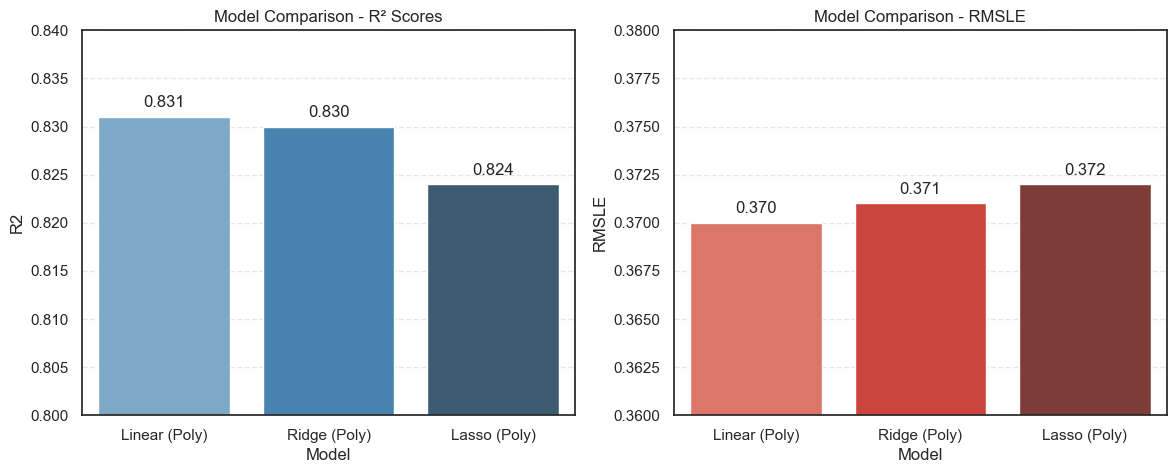

In [32]:
# Put results into a DataFrame
results_df = pd.DataFrame({
    "Model": ["Linear (Poly)", "Ridge (Poly)", "Lasso (Poly)"],
    "R2": [0.831, 0.830, 0.824],
    "RMSLE": [0.370, 0.371, 0.372]
})

# Plot R² Scores
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
sns.barplot(data=results_df, x="Model", y="R2", palette="Blues_d")
plt.title("Model Comparison - R² Scores")
for i, score in enumerate(results_df["R2"]):
    plt.text(i, score + 0.001, f"{score:.3f}", ha="center")
plt.ylim(0.80, 0.84)

# Plot RMSLE Scores
plt.subplot(1, 2, 2)
sns.barplot(data=results_df, x="Model", y="RMSLE", palette="Reds_d")
plt.title("Model Comparison - RMSLE")
for i, score in enumerate(results_df["RMSLE"]):
    plt.text(i, score + 0.0005, f"{score:.3f}", ha="center")
plt.ylim(0.36, 0.38)
plt.show()

## Conclusion

In this project, we explored the **Medical Cost Personal Dataset** and applied different regression models to predict individual healthcare expenses.  

Here are the key takeaways:  

- **Linear Regression with Polynomial Features** gave the best performance, with an **R² of ~0.83** and a **RMSLE of ~0.37**.  
- **Ridge Regression** performed similarly but slightly worse, showing how regularization helps control complexity but may reduce flexibility.  
- **Lasso Regression** also worked well and highlighted how feature selection can simplify the model, though it did not outperform plain linear regression here.  

From the results, we see that:  
- Polynomial features improved model accuracy by capturing non-linear relationships in the data.  
- Regularization (Ridge and Lasso) helps prevent overfitting, especially for higher-degree polynomials.  
- Model choice is not always about the “most complex” one — sometimes a well-tuned linear model is just as effective.  

### Final Thoughts
This project demonstrates how to:  
1. Perform **data exploration and preprocessing**.  
2. Apply and compare **Linear, Ridge, and Lasso Regression**.  
3. Use **cross-validation and evaluation metrics (R², RMSLE)**.  
4. Visualize and interpret model performance.  

As a beginner project, it shows the full **end-to-end machine learning workflow** — from data cleaning to model comparison — and forms a strong foundation for more advanced techniques in the future. 🚀
